In [1]:
import numpy as np
from  matplotlib import pyplot as plt
from matplotlib import patches
import librosa
import librosa.display
import pandas as pd
import scipy
from scipy import ndimage
import time

from utils.plot_tools import *
from utils.feature_tools import normalize_feature_sequence, smooth_downsample_feature_sequence, compute_cost_matrix
from utils.structure_tools import compute_tempo_rel_set

import IPython.display as ipd
from IPython.display import Image, Audio

path_img = '../img/8.content-based_audio_retrieval/'
path_data = '../data_FMP/'

# Feature Design (Chroma, CENS)

- 동일한 음악 작품의 다른 연주를 생각해보면, 모든 버전은 거의 동일한 음표 자료를 기반으로 한다. 동일한 멜로디가 동일한 화성의 맥락 내에서 재생된다. 
- 음악 동기화 시나리오에서 보았듯이 **크로마 기반 오디오 특징**은 이러한 종류의 정보를 캡처하는 데 적합한 중간 수준(mid-level) 표현이다. 크로마 특징(feature)은 서양 음악 표기법에서 사용되는 12개의 피치 $\mathrm{C}$, $\mathrm{C}^\sharp$, $\mathrm{D}$, $\ldots$, $\mathrm{B}$에 기반하며, 각 크로마 벡터는 신호 프레임의 에너지가 12개의 크로마 밴드에 어떻게 분포되는지 나타낸다.
- 시간이 지남에 따라 이러한 분포를 측정하면 멜로디 및 화성 진행과 밀접하게 관련된 시간-크로마 표현(또는 **크로마그램**)이 생성된다.
- 이러한 진행은 종종 동일한 음악의 다른 녹음에 대해서도 유사하므로 크로마 특징을 오디오 매칭 또는 버전 식별과 같은 내용 기반 검색 작업에 적합한 도구로 사용한다.


- 크로마 특징을 계산하는 다양한 방법이 있으며 로그 압축, 정규화 또는 스무딩과 같은 적절한 후처리 단계를 적용하여 크로마 특징의 속성을 조정할 수 있다.
    - 이를 설명하기 위해 베토벤 교향곡 5번의 시작 부분에 대한 두 개의 다른 녹음을 살펴보자(여기서는 피아노로 줄인 악보로 표시됨). 한 공연(21초)은 번스타인이 지휘하고 다른 공연(18초)은 카라얀이 지휘한다. 
    - 코드 셀에서 $10~\mathrm{Hz}$의 특징 속도(feature rate)를 사용하여 Bernstein 및 Karajan 녹음에 대한 기본 크로마 변형을 생성한다. 여기서 각 크로마 벡터는 절반 크기의 윈도우 겹침이 있는 $200~\mathrm{msec}$의 윈도우에 해당한다.

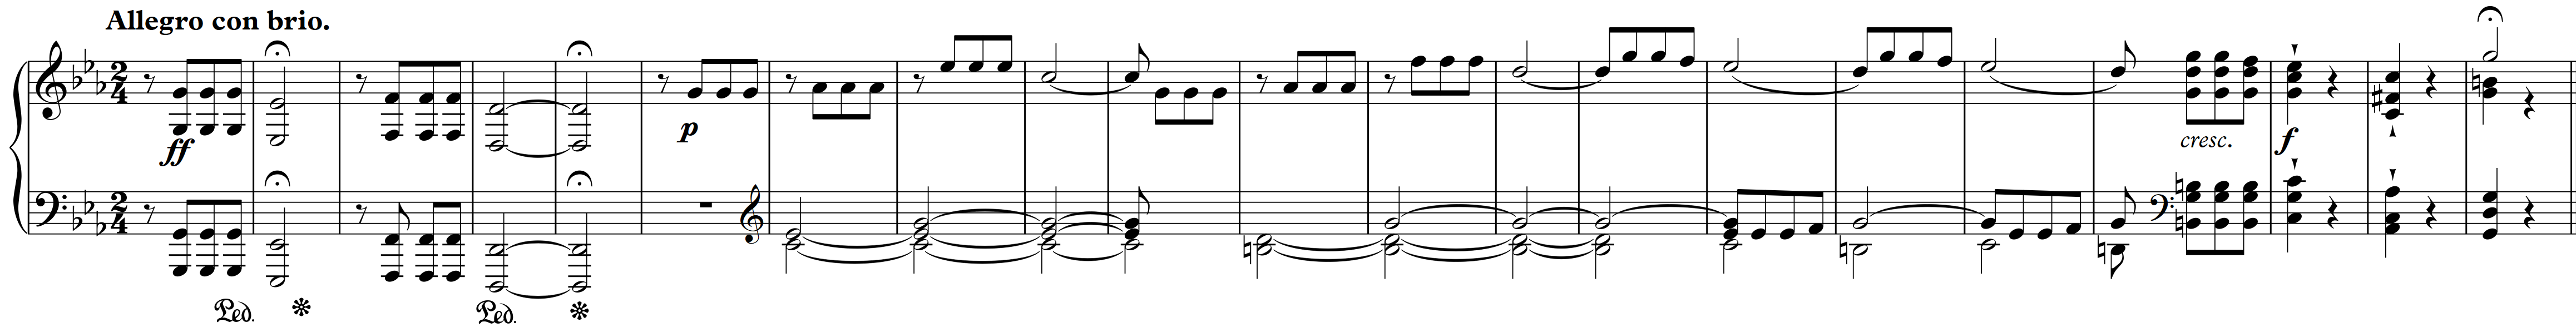

In [2]:
ipd.display(Image(path_img+"FMP_C7_Audio_Beethoven_Op067-01-001-021_Sibelius-Piano.png", width="900px"))

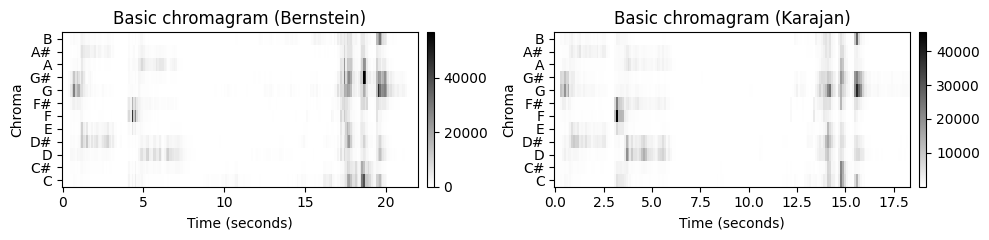

In [3]:
def plot_two_chromagrams(C1, C2, Fs1=1, Fs2=1, title1='', title2='', figsize=(10, 2.5), clim=None):
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.02], wspace=0.05)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.02], wspace=0.05)
    ax1, ax2, ax3, ax4 = plt.subplot(gs1[0]), plt.subplot(gs1[1]), plt.subplot(gs2[0]), plt.subplot(gs2[1])
    
    plot_chromagram(C1, Fs1, ax=[ax1, ax2], clim=clim, title=title1)
    plot_chromagram(C2, Fs2, ax=[ax3, ax4], clim=clim, title=title2)
    
    plt.tight_layout()
    plt.show()

fn_wav1 = 'FMP_C7_Audio_Beethoven_Op067-01-001-021_Bernstein.wav'
fn_wav2 = 'FMP_C7_Audio_Beethoven_Op067-01-001-021_Karajan.wav'
x1, Fs = librosa.load(path_data+fn_wav1)
x2, Fs = librosa.load(path_data+fn_wav2)
ipd.display(Audio(x1,rate=Fs))
ipd.display(Audio(x2,rate=Fs))

N = 4410
H = 2205
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
Fs1 = Fs / H
Fs2 = Fs / H

title1='Basic chromagram (Bernstein)'
title2='Basic chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2)

- 녹음의 다이내믹의 큰 차이를 균형 잡기 위해 정규화(normalization) 기술을 적용할 수 있다. 예를 들어, 유클리드 노름($\ell_2$-norm)과 관련하여 각각의 크로마 벡터를 정규화할 수 있다. 이러한 정규화를 위해 두 가지 구현(`librosa.feature.chroma` 및 `normalize_feature_sequence`)을 사용한다.

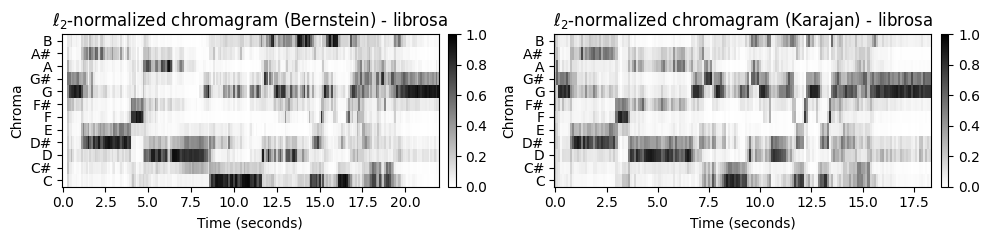

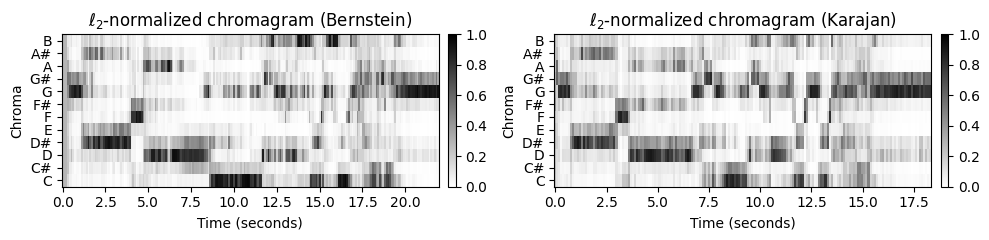

In [4]:
C1_norm_LR = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N) # norm=2
C2_norm_LR = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
title1 = r'$\ell_2$-normalized chromagram (Bernstein)'
title2 = r'$\ell_2$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1_norm_LR, C2_norm_LR, Fs1=Fs1, Fs2=Fs2, title1=title1+' - librosa', title2=title2+' - librosa', clim=[0, 1])

threshold = 0.0001
C1_norm = normalize_feature_sequence(C1, norm='2', threshold=threshold)
C2_norm = normalize_feature_sequence(C2, norm='2', threshold=threshold)
plot_two_chromagrams(C1_norm, C2_norm, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

## Quantization


- 이러한 정규화된 크로마그램 표현이 이미 두 녹음에서 유사한 패턴으로 나타나지만 여전히 성능별 차이가 많이 있다.
- 따라서 한 가지 아이디어는 추가 양자화(quantization) 및 스무딩 절차를 적용하여 로컬 템포, 아티큘레이션 및 음 실행의 변화로 인한 로컬 변동의 영향을 더 줄이는 것이다.
- 이제 이러한 단계가 실제로 구현될 수 있는 방법을 보여주는 구체적인 후처리 절차에 대해 논의한다. 위에서 계산한 기본 크로마 변형으로 시작하여 맨해튼 노름($\ell^1$-norm)으로 각 크로마 벡터를 정규화하여 12개의 크로마 값을 더하면 1이 되게 한다.

- $X=(x_1,x_2,\ldots,x_N)$는 정규화된 크로마 벡터 $x_n\in[0,1]^{12}$, $n\in[1:N]$의 결과 시퀀스를 나타낸다고 하자. 이러한 각 벡터에는 0과 1 사이의 양수 항목만 있다. 다음으로 양자화(quantization) 함수 $Q:[0,1]\to\{0,1,2,3,4\}$를 다음과 같이 정의한다.

$$
    Q(a):=\left\{\begin{array}{llrcl}
    0 & \text{ for } & 0    & \leq \,\, a\,\, < &0.05, \\
    1 & \text{ for } & 0.05 & \leq \,\, a\,\, < &0.1, \\
    2 & \text{ for } & 0.1  & \leq \,\, a\,\, < &0.2, \\
    3 & \text{ for } & 0.2  & \leq \,\, a\,\, < &0.4, \\
    4 & \text{ for } & 0.4  & \leq \,\, a\,\, \leq &1. \\
    \end{array}\right.
$$

- 첫 번째 단계에서 각 $x_n$의 구성 요소에 $Q$를 적용하여 각 크로마 벡터 $x_n=(x_n(0),\ldots,x_n(11))^\top\in[0,1]^{12}$를 양자화하여 다음을 산출한다.
    - $ Q(x_n):=(Q(x_n(0)),\ldots,Q(x_n(11)))^\top.$

- 직관적으로 이 양자화는 해당 크로마 클래스가 예를 들어 신호의 총 에너지의 $40%$ 이상을 포함하는 경우 크로마 구성 요소에 $4$의 값을 할당한다. 또한 $5%$ 임계값 미만의 크로마 구성 요소는 0으로 설정되어 노이즈에 대한 견고성을 높인다. 
- 임계값은 소리 강도(intensity)의 로그 인식을 설명하기 위해 로그 방식으로 선택된다. 예를 들어 벡터 $x_n=(0.02,0.5,0.3,0.07,0.11,0,\ldots,0)^\top$은 벡터 $Q(x_n):=(0,4,3,1,2,0,\ldots,0)^\top$로 변환된다. 

In [5]:
def quantize_matrix(C, quant_fct=None):
    """Quantize matrix values in a logarithmic manner (as done for CENS features)

    Args:
        C (np.ndarray): Input matrix
        quant_fct (list): List specifying the quantization function (Default value = None)

    Returns:
        C_quant (np.ndarray): Output matrix
    """
    C_quant = np.empty_like(C)
    if quant_fct is None:
        quant_fct = [(0.0, 0.05, 0), (0.05, 0.1, 1), (0.1, 0.2, 2), (0.2, 0.4, 3), (0.4, 1, 4)]
    for min_val, max_val, target_val in quant_fct:
        mask = np.logical_and(min_val <= C, C < max_val)
        C_quant[mask] = target_val
    return C_quant

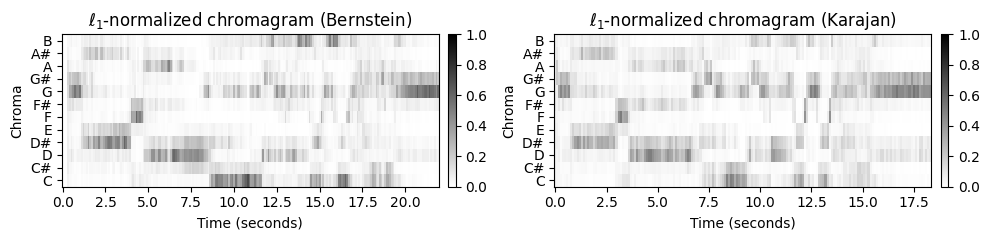

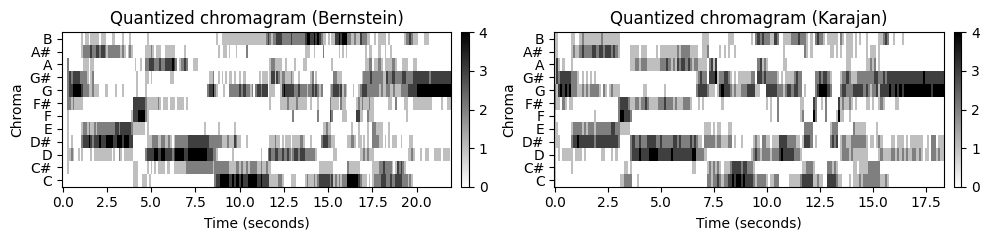

In [6]:
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)

C1_Q = quantize_matrix(C1)
C2_Q = quantize_matrix(C2)

title1=r'$\ell_1$-normalized chromagram (Bernstein)'
title2=r'$\ell_1$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

title1='Quantized chromagram (Bernstein)'
title2='Quantized chromagram (Karajan)'
plot_two_chromagrams(C1_Q, C2_Q, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 4])

## 스무딩 및 다운샘플링 (Smoothing and Downsampling)

- 두 번째 단계에서 양자화된 시퀀스 $(Q(x_1),\ldots,Q(x_N))$는 시간 차원을 따라 더욱 평활화(smoothed)된다.
- 이를 위해 **스무딩 윈도우**(**smoothing window**)(예: Hann window)의 길이를 결정하는 숫자 $\ell\in\mathbb{N}$를 고정한 다음, 시퀀스 $(Q(x_1),\ldots,Q(x_N))$의 12개 구성 요소 각각의 로컬 평균(window 함수에 의해 가중됨)을 고려한다. 이는 다시 음수가 아닌 항목의 $12$ 차원 벡터의 시퀀스를 생성한다. 
- 마지막 단계에서 이 시퀀스는 $d$ 배만큼 **다운샘플링**되고 결과 벡터는 유클리드 노름($\ell^2$-norm)에 따라 정규화된다. 양자화와 평활화의 두 단계는 $\ell$ 연속 벡터의 윈도우에 대한 에너지 분포의 가중 통계를 계산하는 것으로 생각할 수 있다. 
- 따라서 결과의 피처를 $\mathrm{CENS}^{\ell}_{d}$(**chroma energy normalized statistics**) (**크로마 에너지 정규화 통계**)라고 한다.
- 다음 코드 셀에서는 CENS 특징(feature) 계산에 관련된 모든 단계를 요약하는 함수를 본다.

- **CENS** 특징의 주요 아이디어는 상대적으로 큰 윈도우에 대한 통계를 통해 트릴이나 아르페지오와 같은 음 그룹의 템포, 아티큘레이션 및 실행에서 로컬 편차를 완화한다는 것이다. 
- 이 효과를 설명하기 위해 다음 예에서 두 베토벤 공연에 대한 $\mathrm{CENS}^{41}_{10}$-features의 시퀀스를 보여준다. 원래 크로마 시퀀스에 대한 특징 속도 $10~\mathrm{Hz}$에서 시작하여, $\ell=41$ 매개변수는 $4100~\mathrm{msec}$의 윈도우 크기에 해당한다.
- 또한 다운샘플링 매개변수 $d=10$를 사용하면 특징 속도가 $1~\mathrm{Hz}$(초당 하나의 기능)로 감소한다. 
- 원본 크로마 시퀀스와 비교할 때, 두 공연의 결과 CENS 시퀀스는 훨씬 더 높은 수준의 유사성을 보유하면서도 일부 특징적인 음악 정보를 캡처한다.

In [7]:
def compute_cens_from_chromagram(C, Fs=1, ell=41, d=10, quant=True):
    """Compute CENS features from chromagram

    Args:
        C (np.ndarray): Input chromagram
        Fs (scalar): Feature rate of chromagram (Default value = 1)
        ell (int): Smoothing length (Default value = 41)
        d (int): Downsampling factor (Default value = 10)
        quant (bool): Apply quantization (Default value = True)

    Returns:
        C_CENS (np.ndarray): CENS features
        Fs_CENS (scalar): Feature rate of CENS features
    """
    C_norm = normalize_feature_sequence(C, norm='1')
    C_Q = quantize_matrix(C_norm) if quant else C_norm

    C_smooth, Fs_CENS = smooth_downsample_feature_sequence(C_Q, Fs, filt_len=ell,
                                                                     down_sampling=d, w_type='hann')
    C_CENS = normalize_feature_sequence(C_smooth, norm='2')

    return C_CENS, Fs_CENS

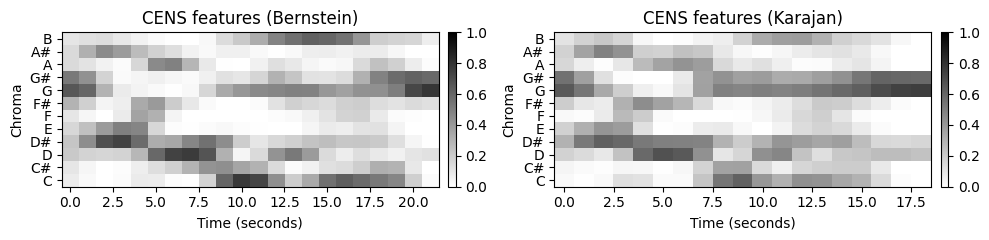

In [8]:
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)

C1_CENS, Fs1_CENS = compute_cens_from_chromagram(C1, Fs1)
C2_CENS, Fs2_CENS = compute_cens_from_chromagram(C2, Fs2)

title1='CENS features (Bernstein)'
title2='CENS features (Karajan)'
plot_two_chromagrams(C1_CENS, C2_CENS, Fs1=Fs1_CENS, Fs2=Fs2_CENS, title1=title1, title2=title2, clim=[0, 1])

## 매개변수 설정 (Parameter Settings)

- CENS 개념은 두 가지 주요 매개변수 $\ell\in\mathbb{N}$ 및 $d\in\mathbb{N}$에 따라 $\mathrm{CENS}^{\ell}_{d}$ 크로마 특징 군을 생성한다.  설명된 절차는 원래 크로마그램의 비용 집약적인 계산을 반복하지 않고 특징 특이성(specificity)과 해상도(resolution)를 조정하는 계산적으로 저렴한 방법을 소개한다. 다음 그림에서는 다양한 스무딩 및 다운샘플링 매개변수를 사용하는 CENS 특징 표현을 보여준다.

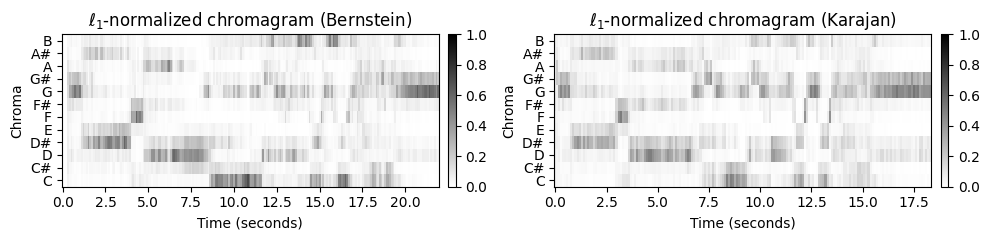

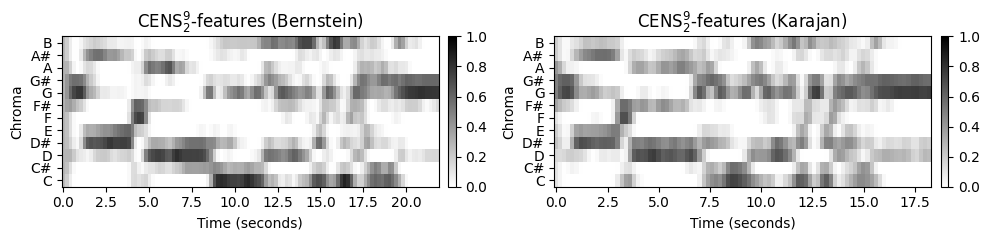

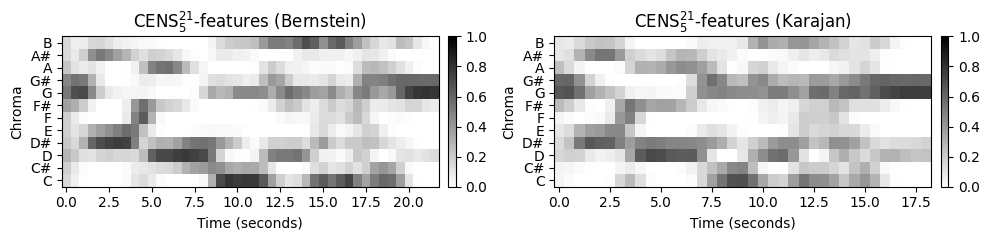

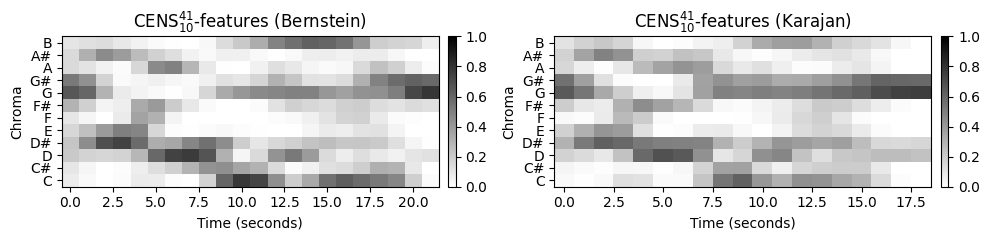

In [9]:
title1=r'$\ell_1$-normalized chromagram (Bernstein)'
title2=r'$\ell_1$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

parameter_set = [(9, 2), (21, 5), (41, 10)]
for parameter in parameter_set:
    ell = parameter[0]
    d = parameter[1]
    C1_CENS, Fs1_CENS = compute_cens_from_chromagram(C1, Fs1, ell=ell, d=d)
    C2_CENS, Fs2_CENS = compute_cens_from_chromagram(C2, Fs2, ell=ell, d=d)
    title1=r'CENS$^{%d}_{%d}$-features (Bernstein)' % (ell, d)
    title2=r'CENS$^{%d}_{%d}$-features (Karajan)' % (ell, d)
    plot_two_chromagrams(C1_CENS, C2_CENS, Fs1=Fs1_CENS, Fs2=Fs2_CENS,
                         title1=title1, title2=title2, clim=[0, 1])

- CENS 피처는 어떤 크로마그램 표현으로도 시작하여 계산할 수 있다. 예를 들어 STFT 기반 크로마그램을 사용하는 대신 **다중 속도 필터 뱅크**(**multirate filter bank**)를 기반으로 하는 크로마그램으로 시작할 수 있다. 

<img src="../img/8.content-based_audio_retrieval/FMP_C7S3_CENS_WASPAA.png" width="700px" align="left" alt="C7_CENS">
<br clear="all" />

- 라이브러리 LibROSA에는 CENS 기능을 계산하는 함수(`librosa.feature.chroma_cens`)도 포함되어 있다. 다운샘플링은 해당 함수 외부에서 수행되어야 한다(예: `C_CENS[:, ::d]` 사용).

# 대각선 매칭 (Diagonal Matching)

## 매칭 함수 (Matching Function)

- 아래의 서브시퀀스(subsequence) 매칭 기법은 **오디오 매칭** 작업을 동기로 합니다. 오디오 매칭의 목표는 짧은 쿼리 오디오 클립에 음악적으로 해당하는 모든 오디오 발췌 부분을 검색하는 것이다.
- 추상적인 관점에서 $X=(x_1,x_2,\ldots,x_N)$ 및 $Y=(y_1,y_2,\ldots,y_M)$를 쿼리 $\mathcal{Q}$ 및 문서 $\mathcal{D}$를 각각 대표하는 두 개의 피처 시퀀스라고 하자.
- 쿼리의 길이 $N$는 일반적으로 데이터베이스 문서의 길이 $M$에 비해 짧다. 
- 쿼리 $\mathcal{Q}$가 $\mathcal{D}$에 어떻게든 "포함"되어 있는지 확인하기 위해 시퀀스 $X$를 시퀀스 $Y$로 이동하고 $X$를 $Y$의 적절한 하위 시퀀스와 로컬에서 비교한다. 
- 유사하거나 동등하게 $X$에 대한 작은 거리를 갖는 $Y$의 모든 하위 시퀀스는 쿼리에 대해 **일치**(match)하는 것으로 간주된다.

- $X$를 $Y$의 하위 시퀀스와 로컬에서 비교하는 방법에는 여러 가지가 있다. 이제 **대각선 매칭**(**diagonal matching**)이라는 간단한 절차를 소개한다.

- 우선, 시퀀스 $X$와 $Y$의 크로마 벡터를 비교하기 위해 로컬 비용 측정(또는 로컬 거리 측정)을 고정해야 한다. 다음에서는 **유클리드 노름**과 관련하여 모든 특징이 정규화되었다고 가정하고 **내적**을 기반으로 거리 측정 $c$를 사용한다.
    - $c(x,y) = 1- \langle x,y\rangle = 1 - \sum_{k=1}^K x(k)y(k)$
    - 2개의 $K$차원 벡터 $x\in\mathbb{R}^K$ 및 $y\in\mathbb{R}^K$
    - $\|x\|_2=\|y\|_2=1$.

- 또한, 모든 특징 벡터가 **음이 아닌(nonnegative) 항목**을 갖는다고 가정하면 $c(x,y)\in[0,1]$와 $c(x,y)=0$는 $x=y$일 때만 그렇다. 
- 동일한 길이를 공유하는 두 개의 특징 시퀀스를 비교하는 한 가지 간단한 방법은 두 시퀀스의 해당 벡터 사이의 평균 거리를 계산하는 것이다.
- 이렇게 하면 쿼리 시퀀스 $X=(x_1,\ldots,x_N)$와 쿼리와 동일한 길이 $N$를 갖는 $Y$의 모든 하위 시퀀스 $(y_{1+m},\ldots,y_{N+m})$를 비교할 수 있다.$m\in[0:M-N]$이 이동 인덱스를 나타낸다. 
- 이 절차는 다음과 같이 정의된 **매칭 함수** $\Delta_\mathrm{Diag}:[0:M-N]\to\mathbb{R}$를 생성한다.
     -$\Delta_\mathrm{Diag}(m) := \frac{1}{N}\sum_{n=1}^{N} c(x_n,y_{n+m}).$
     
- 이제 이 매칭 함수가 계산되는 방식을 약간 재구성한다. $\mathbf{C}\in\mathbb{R}^{N\times M}$가 다음과 같이 주어진 **비용 매트릭스**라고 하자.
    - $ \mathbf{C}(n,m):=c(x_n,y_m) $
    - for $n\in[1:N]$ and $m\in[1:M]$

- 그러면 다음 그림과 같이 $\mathbf{C}$ 행렬의 대각선을 합산하여 $\Delta_\mathrm{Diag}(m)$ 값을 얻는다(쿼리 길이에 의한 정규화까지). 이는 이 절차가 "대각선" 매칭으로 불리는 이유를 설명한다.

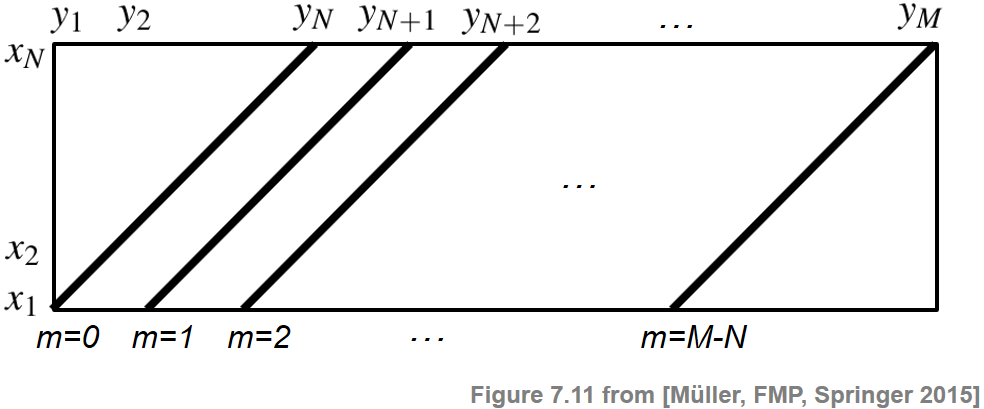

In [10]:
Image(path_img+"FMP_C7_F11.png", width="400px")

- 다음 코드 셀에서는 대각선 매칭 절차를 구현하고 생성한 합성 시퀀스 $X$ 및 $Y$에 적용한다. 다음 예에서 시퀀스 $Y$는 $X$와 유사한 5개의 하위시퀀스를 포함한다(각각 위치 $m=20$, $40$, $60$, $80$, $100$에서 시작).
     * $m=20$에서 시작하는 첫 번째 항목은 $X$의 정확한 복사본이다.
     * $m=40$ 및 $m=60$의 발생은 $X$의 노이즈 버전이다.
     * $m=80$의 발생은 $X$의 확장된(느린) 버전이다.
     * $m=100$의 발생은 $X$의 압축된(빠른) 버전이다.

- 다음 그림에서 볼 수 있듯이 매칭 함수 $\Delta_\mathrm{Diag}$는 예상 위치에서 로컬 최소값을 나타낸다. $m=20$의 첫 번째 최소값은 0이지만 $m=40$ 및 $m=60$의 다음 두 최소값은 여전히 두드러진다(일치 값은 0에 가깝다). 그러나 늘림과 압축으로 인해 대각선 매칭 절차는 $m=80$ 및 $m=100$에서 마지막 두 개의 하위시퀀스를 잘 캡처할 수 없다.


In [11]:
def scale_tempo_sequence(X, factor=1):
    """Scales a sequence (given as feature matrix) along time (second dimension)

    Args:
        X (np.ndarray): Feature sequences (given as K x N matrix)
        factor (float): Scaling factor (resulting in length "round(factor * N)"") (Default value = 1)

    Returns:
        X_new (np.ndarray): Scaled feature sequence
        N_new (int): Length of scaled feature sequence
    """
    N = X.shape[1]
    t = np.linspace(0, 1, num=N, endpoint=True)
    N_new = np.round(factor * N).astype(int)
    t_new = np.linspace(0, 1, num=N_new, endpoint=True)
    X_new = scipy.interpolate.interp1d(t, X, axis=1)(t_new)
    return X_new, N_new


def cost_matrix_dot(X, Y):
    """Computes cost matrix via dot product

    Args:
        X (np.ndarray): First sequence (K x N matrix)
        Y (np.ndarray): Second sequence (K x M matrix)

    Returns:
        C (np.ndarray): Cost matrix
    """
    return 1 - np.dot(X.T, Y)


def matching_function_diag(C, cyclic=False):
    """Computes diagonal matching function

    Args:
        C (np.ndarray): Cost matrix
        cyclic (bool): If "True" then matching is done cyclically (Default value = False)

    Returns:
        Delta (np.ndarray): Matching function
    """
    N, M = C.shape
    assert N <= M, "N <= M is required"
    Delta = C[0, :]
    for n in range(1, N):
        Delta = Delta + np.roll(C[n, :], -n)
    Delta = Delta / N
    if cyclic is False:
        Delta[M-N+1:M] = np.inf
    return Delta

In [12]:
# Create snythetic example for sequences X and Y
N = 15
M = 130
feature_dim = 12
np.random.seed(2)
X = np.random.random((feature_dim, N))
Y = np.random.random((feature_dim, M))
Y[:, 20:20+N] = X
Y[:, 40:40+N] = X + 0.5 * np.random.random((feature_dim, N))
Y[:, 60:60+N] = X + 0.8 * np.random.random((feature_dim, N))
X_slow, N_slow = scale_tempo_sequence(X, factor=1.25)
Y[:, 80:80+N_slow] = X_slow
X_fast, N_fast = scale_tempo_sequence(X, factor=0.8)
Y[:, 100:100+N_fast] = X_fast
Y = librosa.util.normalize(Y, norm=2)
X = librosa.util.normalize(X, norm=2)

# Compute cost matrix and matching function
C = cost_matrix_dot(X, Y)
Delta = matching_function_diag(C)

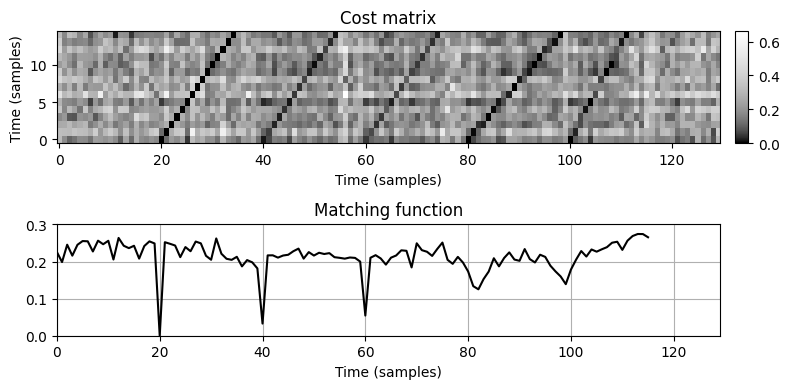

In [13]:
# Visualization
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [1, 1]}, figsize=(8, 4))  
cmap = compressed_gray_cmap(alpha=-10, reverse=True)
plot_matrix(C, title='Cost matrix', xlabel='Time (samples)', ylabel='Time (samples)', 
                     ax=[ax[0, 0], ax[0, 1]], colorbar=True, cmap=cmap)

plot_signal(Delta, ax=ax[1,0], xlabel='Time (samples)', ylabel='',
                     title = 'Matching function', color='k')
ax[1, 0].grid()
ax[1, 1].axis('off')
plt.tight_layout()

## 검색 절차 (Retrieval Procedure)

- 이제 쿼리 조각과 유사한 모든 일치 항목을 검색하기 위해 매칭 함수를 적용하는 방법에 대해 설명한다.
- 다음에서는 데이터베이스가 단일 문서 $\mathcal{D}$(예: 모든 문서 시퀀스 연결)로 표현된다고 가정한다. $\mathcal{Q}$와 $\mathcal{D}$ 사이의 최상의 매칭을 결정하기 위해 매칭 함수 $\Delta_\mathrm{Diag}$를 최소화하는 인덱스 $m^\ast\in[0:M-N]$를 찾기만 하면 된다.
    - $m^\ast := \underset{m\in[0:M-N]}{\mathrm{argmin}} \,\,\Delta_\mathrm{Diag}(m).$

- 최상의 일치는 다음의 하위시퀀스로 주어진다.
    - $Y(1+m^\ast:N+m^\ast) := (y_{1+m^\ast},\ldots,y_{N+m^\ast}).$
   
- 더 많은 일치 항목을 얻기 위해 가장 일치하는 이웃을 제외한다. 예를 들어, $m\in [m^\ast-\rho:m^\ast+\rho]\cap [0:M-N]$에 대해 $\Delta_\mathrm{Diag}(m)=\infty$를 설정하는 식으로 $m^\ast$ 주변의 $\rho= \lfloor N/2 \rfloor$ 이웃을 제외할 수 있다.
- 이렇게 하면 후속의 일치 항목이 쿼리 길이의 절반 이상 겹치지 않는다. 후속의 일치 항목을 찾기 위해 특정 수의 일치 항목을 얻거나 지정된 거리 임계값을 초과할 때까지 후자의 절차를 반복한다.

- 다음 코드 셀에서 이 검색 절차를 구현한다. $\rho$ 매개변수 외에도 일치하는 값을 제한하기 위한 $\tau$ 매개변수(즉, $\Delta_\mathrm{Diag}(m^\ast)\leq \tau$가 필요함)와 검색할 최대 일치 항목 수를 지정한다.

In [14]:
def mininma_from_matching_function(Delta, rho=2, tau=0.2, num=None):
    """Derives local minima positions of matching function in an iterative fashion

    Args:
        Delta (np.ndarray): Matching function
        rho (int): Parameter to exclude neighborhood of a matching position for subsequent matches (Default value = 2)
        tau (float): Threshold for maximum Delta value allowed for matches (Default value = 0.2)
        num (int): Maximum number of matches (Default value = None)

    Returns:
        pos (np.ndarray): Array of local minima
    """
    Delta_tmp = Delta.copy()
    M = len(Delta)
    pos = []
    num_pos = 0
    rho = int(rho)
    if num is None:
        num = M
    while num_pos < num and np.sum(Delta_tmp < tau) > 0:
        m = np.argmin(Delta_tmp)
        pos.append(m)
        num_pos += 1
        Delta_tmp[max(0, m - rho):min(m + rho, M)] = np.inf
    pos = np.array(pos).astype(int)
    return pos


def matches_diag(pos, Delta_N):
    """Derives matches from positions in the case of diagonal matching

    Args:
        pos (np.ndarray or list): Starting positions of matches
        Delta_N (int or np.ndarray or list): Length of match (a single number or a list of same length as Delta)

    Returns:
        matches (np.ndarray): Array containing matches (start, end)
    """
    matches = np.zeros((len(pos), 2)).astype(int)
    for k in range(len(pos)):
        s = pos[k]
        matches[k, 0] = s
        if isinstance(Delta_N, int):
            matches[k, 1] = s + Delta_N - 1
        else:
            matches[k, 1] = s + Delta_N[s] - 1
    return matches


def plot_matches(ax, matches, Delta, Fs=1, alpha=0.2, color='r', s_marker='o', t_marker=''):
    """Plots matches into existing axis

    Args:
        ax: Axis
        matches: Array of matches (start, end)
        Delta: Matching function
        Fs: Feature rate (Default value = 1)
        alpha: Transparency pramaeter for match visualization (Default value = 0.2)
        color: Color used to indicated matches (Default value = 'r')
        s_marker: Marker used to indicate start of matches (Default value = 'o')
        t_marker: Marker used to indicate end of matches (Default value = '')
    """
    y_min, y_max = ax.get_ylim()
    for (s, t) in matches:
        ax.plot(s/Fs, Delta[s], color=color, marker=s_marker, linestyle='None')
        ax.plot(t/Fs, Delta[t], color=color, marker=t_marker, linestyle='None')
        rect = patches.Rectangle(((s-0.5)/Fs, y_min), (t-s+1)/Fs, y_max, facecolor=color, alpha=alpha)
        ax.add_patch(rect)

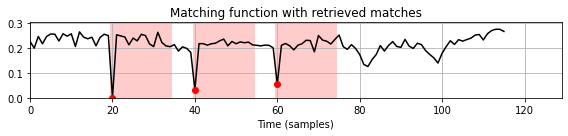

In [15]:
pos = mininma_from_matching_function(Delta, rho=N//2, tau=0.12, num=None)
matches = matches_diag(pos, N)

fig, ax, line = plot_signal(Delta, figsize=(8, 2), xlabel='Time (samples)', 
                                     title = 'Matching function with retrieved matches', 
                                     color='k')
ax.grid()
plot_matches(ax, matches, Delta)

##  다중 쿼리를 이용한 매칭 함수 (Matching Function Using Multiple Queries)

- 이 기본적인 매칭 절차는 쿼리의 템포가 매칭할 구간 내 템포와 대략적으로 일치하는 경우에 잘 작동한다. 그러나 앞의 예에서도 알 수 있듯이 대각선 일치는 데이터베이스 하위시퀀스가 늘려지거나 압축된 버전의 쿼리일 때 문제가 된다. 이러한 템포 차이를 보완하기 위해 **다중 쿼리 전략**을 적용할 수 있다.
- 아이디어는 다음과 같다.
    * 다양한 템포를 시뮬레이트하는 스케일링 작업을 적용하여 여러 버전의 쿼리를 생성한다.
    * 대각선 매칭을 사용하여 스케일링된 각 버전에 대해 별도의 매칭 함수를 계산한다.
    * 모든 결과 매칭 함수를 최소화하여 단일 매칭 함수를 생성한다.
     
- 이 아이디어는 SSM의 경로 구조를 향상시키기 위한 **다중 필터링 접근 방식**(**multiple-filtering approach**)과 유사하다. 다음 구현에서는 예상되는 상대 템포 차이의 범위를 샘플링하는 $\Theta$ 집합을 도입한다. 음악 검색에서 일치하는 섹션 간의 상대적인 템포 차이가 $50$퍼센트보다 큰 경우는 거의 발생하지 않는다. 따라서 $\Theta$는 대략 $-50$ ~ $+50$ 퍼센트의 템포 변화를 커버하도록 선택할 수 있다. 예를 들어, 집합 $\Theta=\{0.66,0.81,1.00,1.22,1.50\}$(로그 간격의 템포 매개변수 포함)는 대략 $−50$에서 $+50$ 퍼센트까지의 템포 변화를 포함한다. (이 집합은 `compute_tempo_rel_set` 함수로 계산할 수 있다.)

In [16]:
def matching_function_diag_multiple(X, Y, tempo_rel_set=[1], cyclic=False):
    """Computes diagonal matching function using multiple query strategy

    Args:
        X (np.ndarray): First sequence (K x N matrix)
        Y (np.ndarray): Second sequence (K x M matrix)
        tempo_rel_set (np.ndarray): Set of relative tempo values (scaling) (Default value = [1])
        cyclic (bool): If "True" then matching is done cyclically (Default value = False)

    Returns:
        Delta_min (np.ndarray): Matching function (obtained by from minimizing over several matching functions)
        Delta_N (np.ndarray): Query length of best match for each time position
        Delta_scale (np.ndarray): Set of matching functions (for each of the scaled versions of the query)
    """
    M = Y.shape[1]
    num_tempo = len(tempo_rel_set)
    Delta_scale = np.zeros((num_tempo, M))
    N_scale = np.zeros(num_tempo)
    for k in range(num_tempo):
        X_scale, N_scale[k] = scale_tempo_sequence(X, factor=tempo_rel_set[k])
        C_scale = cost_matrix_dot(X_scale, Y)
        Delta_scale[k, :] = matching_function_diag(C_scale, cyclic=cyclic)
    Delta_min = np.min(Delta_scale, axis=0)
    Delta_argmin = np.argmin(Delta_scale, axis=0)
    Delta_N = N_scale[Delta_argmin]
    return Delta_min, Delta_N, Delta_scale

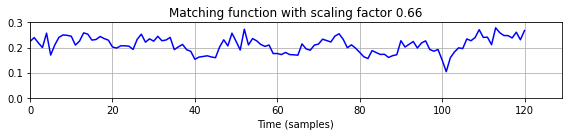

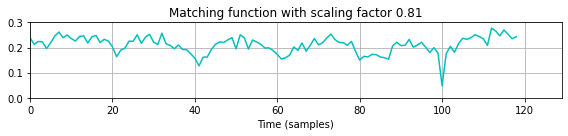

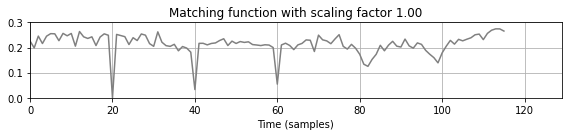

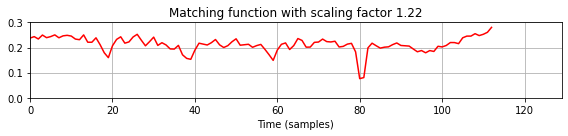

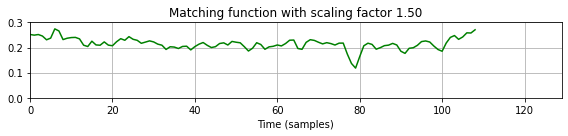

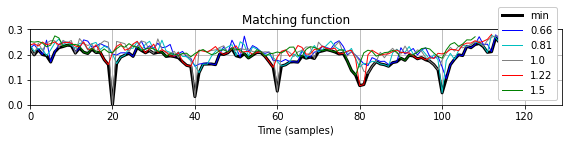

In [17]:
tempo_rel_set = [0.66, 0.81, 1.00, 1.22, 1.50]
color_set = ['b', 'c', 'gray', 'r', 'g']
num_tempo = len(tempo_rel_set)

Delta_min, Delta_N, Delta_scale = matching_function_diag_multiple(X, Y,  tempo_rel_set=tempo_rel_set,
                                                                  cyclic=False)

for k in range(num_tempo):
    plot_signal(Delta_scale[k,:], figsize=(8, 2), xlabel='Time (samples)',
                         title = 'Matching function with scaling factor %.2f' % tempo_rel_set[k], 
                         color=color_set[k], ylim=[0, 0.3])
    plt.grid()
    
fig, ax, line = plot_signal(Delta_min, figsize=(8, 2), xlabel='Time (samples)',
                     title = 'Matching function', color='k', ylim=[0,0.3], linewidth=3, label='min')
ax.grid()
for k in range(num_tempo):
    ax.plot(Delta_scale[k, :], linewidth=1, color=color_set[k], label=tempo_rel_set[k])
                     
plt.legend(loc='lower right', framealpha=1);

- 다중 쿼리 매칭 함수에서 확장되거나 압축된 쿼리 버전에 해당하는 하위시퀀스는 이제 값이 0에 훨씬 가까운 로컬 최소값으로 표시된다. 결과적으로, 위의 검색 절차(동일한 매개변수 설정 사용)는 이제 예상되는 일치 항목을 생성한다. 일치하는 하위 시퀀스의 길이는 고려된 모든 쿼리 버전에 대해 최소 일치 값을 생성하는 확장된 쿼리에서 파생된다. 따라서 아래 그림에서도 표시된 것처럼 길이는 원본(확장되지 않은) 쿼리의 길이 $N$과 다를 수 있다.

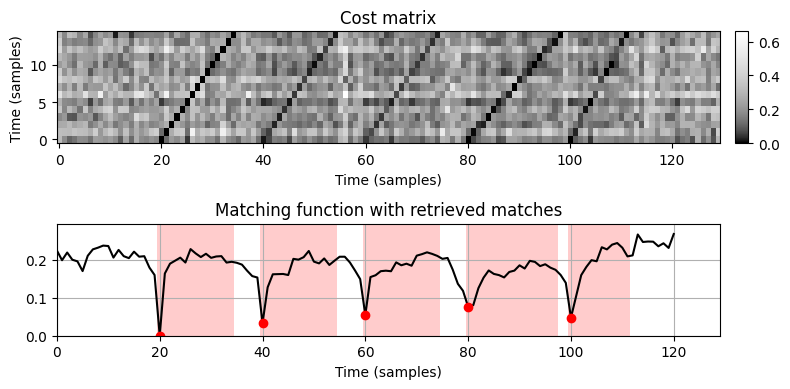

In [18]:
pos = mininma_from_matching_function(Delta_min, rho=N//2, tau=0.12, num=None)
matches = matches_diag(pos, Delta_N)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [3, 3]}, figsize=(8, 4))  
cmap = compressed_gray_cmap(alpha=-10, reverse=True)
plot_matrix(C, title='Cost matrix', xlabel='Time (samples)', ylabel='Time (samples)', 
                     ax=[ax[0, 0], ax[0, 1]], colorbar=True, cmap=cmap)

plot_signal(Delta_min, ax=ax[1, 0], xlabel='Time (samples)', 
                     title = 'Matching function with retrieved matches', color='k')

ax[1,0].grid()
plot_matches(ax[1, 0], matches, Delta_min)
ax[1,1].axis('off')
plt.tight_layout()

* 대각선 매칭에 대한 대안으로 동적 시간 워핑(DTW)의 변형을 사용하여 로컬 템포 변형을 처리할 수 있는 대안을 소개한다.

# Subsequence DTW

## Gobal and Subsequence Alignment

- DTW(Dynamic Time Warping)에 대한 노트북(4.2.)에서 두 개의 특징 시퀀스를 비교할 때 템포 차이를 어떻게 처리할 수 있는지 연구한 바 있다. **워핑 경로**의 개념을 기반으로 DTW 알고리즘을 사용하여 두 시퀀스 간의 최적 **전역 정렬**(**global alignment**)을 계산했다.
- 오디오 매칭 시나리오에서는 정렬 작업이 약간 다르다. 주어진 두 시퀀스 간의 전체 정렬을 찾는 대신 목표는 더 짧은 시퀀스에 최적으로 맞는 긴 시퀀스 내의 하위 시퀀스를 찾는 것이다.

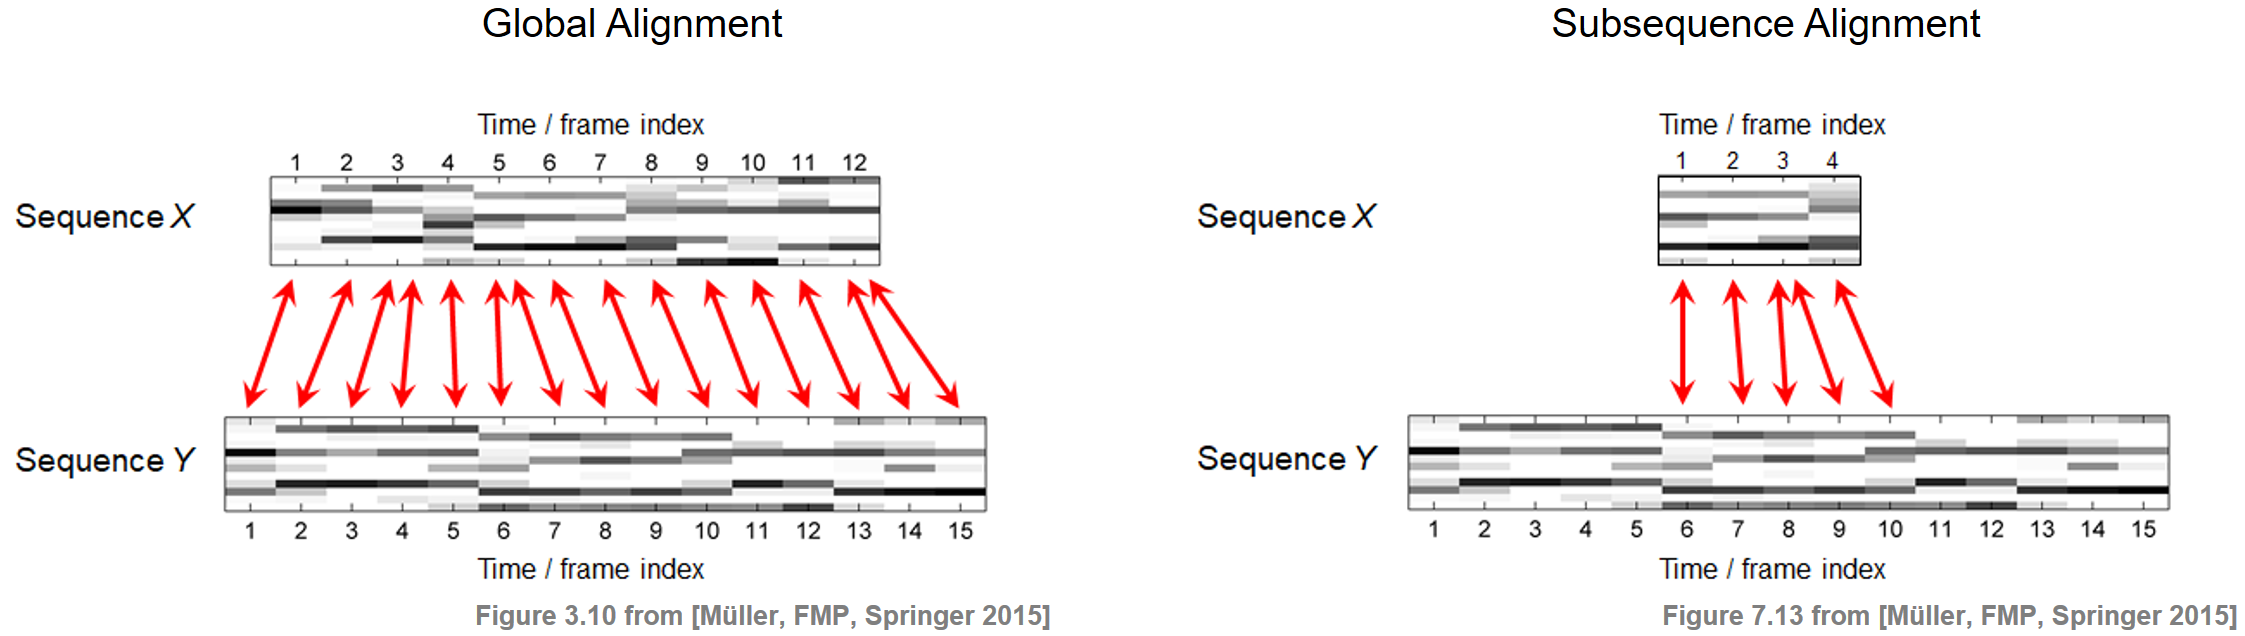

In [19]:
Image(path_img+ "FMP_C7_F13+.png", width="800px")

## Problem Formalization

- $X=(x_1,x_2,\ldots,x_N)$ 및 $Y=(y_1,y_2,\ldots,y_M)$가 특징 공간 $\mathcal{F}$에 대한 두 개의 특징 시퀀스라고 가정하자. 길이 $M$는 길이 $N$보다 훨씬 크다. 또한, $c:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$를 로컬 비용의 측정이라고 하고, $\mathbf{C}$를 $\mathbf{C}(n,m)=c(x_n,y_m)$ (for $n\in[1:N]$, $m\in[1:M]$)로 주어진 결과 비용 행렬이라고 하자. 

- $a,b\in[1:M]$와 $a\leq b$의 두 인덱스에 대해, $Y$의 하위 시퀀스를 나타내는 다음 표기를 사용한다.
    - $Y(a:b):=(y_a,y_{a+1},\ldots,y_b)$

- 전역 DTW 거리를 기반으로 매칭 문제는 다음과 같은 최적화 작업으로 공식화할 수 있다. $X$까지의 DTW 거리를 최소화하는 $Y$의 하위 시퀀스($Y$의 모든 가능한 하위 시퀀스에서)를 찾는다. 즉, 다음에 의해 정의된 인덱스를 결정하는 것이다.
    - $    (a^\ast,b^\ast) := \underset{(a,b): 1\leq a\leq b\leq M}{\mathrm{argmin}}
    \mathrm{DTW}\big( X\,,\, Y(a:b)\big).$

## Subsequence DTW Algorithm

- $(a^\ast,b^\ast)$ 찾기에는 두 가지 종류의 최적화 단계가 포함된다.

- 먼저 $Y$의 모든 가능한 하위 시퀀스를 고려하여 최적의 하위 시퀀스를 찾아야 한다.

- 둘째, 각 하위시퀀스에 대해 $X$까지의 DTW 거리를 계산해야 하며, 여기에는 최적 워핑 경로의 비용을 결정하기 위한 최적화가 포함된다.

- 인덱스 $a^\ast$ 및 $b^\ast$와 $X$ 및 하위 시퀀스 $Y(a^\ast:b^\ast)$ 사이의 모든 최적 정렬, 모두 단일 최적화 프레임워크 내에서 계산할 수 있다.

- 이를 위해 원래 DTW 알고리즘의 약간의 수정만 필요하다. 기본 아이디어는 $X$와의 정렬에서 $Y$의 시작과 끝에 생략을 허용하는 것이다.

- 원래 DTW 알고리즘과 마찬가지로 $\mathbf{D}$로 표시되는 $N\times M$ **누적 비용 행렬**을 정의한다. 이 행렬의 첫 번째 열은 다음과 같이 설정하여 초기화된다.
    - $\mathbf{D}(n,1):=\sum_{k=1}^{n} \mathbf{C}(k,1)$
    - for $n\in [1:N]$. 
    
- 그러나 $\mathbf{D}$의 첫 번째 행은 이제 다음과 같이 초기화됩니다.
    - $\mathbf{D}(1,m):= \mathbf{C}(1,m)$
    - for $m\in [1:M]$. 

- 이 초기화(initialization)는 비용을 누적하지 않고 시퀀스 $Y$의 모든 위치에서 시작할 수 있게 하여 $X$와 일치할 때 $Y$의 시작 부분을 건너뛸 수 있게 한다. 
- $\mathbf{D}$의 나머지 값은 원래 DTW 알고리즘에서와 같이 재귀적으로 정의된다.
    - $\mathbf{D}(n,m) = \mathbf{C}(n,m) + \mathrm{min}\big\{ \mathbf{D}(n-1,m-1), \mathbf{D}(n-1,m), \mathbf{D}(n,m-1) \big\}$
    - for $n\in[2:N]$ and $m\in[2:M]$. 

- 마지막으로, 전역 DTW 거리를 얻기 위해 계수 $\mathbf{D}(N,M)$만 보는 것이 아니라, 두 번째 수정은 전체 마지막 행 $\mathbf{D}(N,m)$ (for $m\in[1:M]$)을 고려하는 것이다. 이 행에서 인덱스 $b^\ast$는 다음과 같이 결정될 수 있다.
     - $b^\ast = \underset{b\in[1:M]}{\mathrm{argmin}} \,\,\mathbf{D}(N,b).$

- 이 행에서 **비용-최소화 인덱스**를 선택하면(원래 DTW 접근 방식에서와 같이 마지막 인덱스를 사용하는 대신), $X$와 일치할 때 $Y$의 끝을 건너뛸 수 있게 한다. 
- 시작 인덱스 $a^\ast$는 행렬 $\mathbf{D}(N,m)$에서 직접 읽을 수 없다. $a^\ast$를 결정하려면 고전적인 DTW에서와 같이 **역추적(backtracking) 절차**를 적용하여 최적의 워핑 경로를 구성해야 한다. 그러나 이번에는 ($q_1=(N,M)$ 대신) $q_1=(N,b^\ast)$로 시작하고 $\mathbf{D}$의 첫 번째 행이 일부 요소 $q_L=(1,m)$, $m\in[1:M]$($q_L=(1,1))$ 대신)에 도달하면 멈춘다. 인덱스 $a^\ast\in[1:M]$는 이 인덱스 $m$에 의해 결정됩니다. 
- 또한 경로 $(q_L,q_{L-1},\ldots,q_1)$는 시퀀스 $X$와 하위 시퀀스 $Y(a^\ast:b^\ast)$ 사이의 최적 워핑 경로를 정의한다. 하위 시퀀스 DTW 알고리즘은 다음 표에 의해 구체화된다.

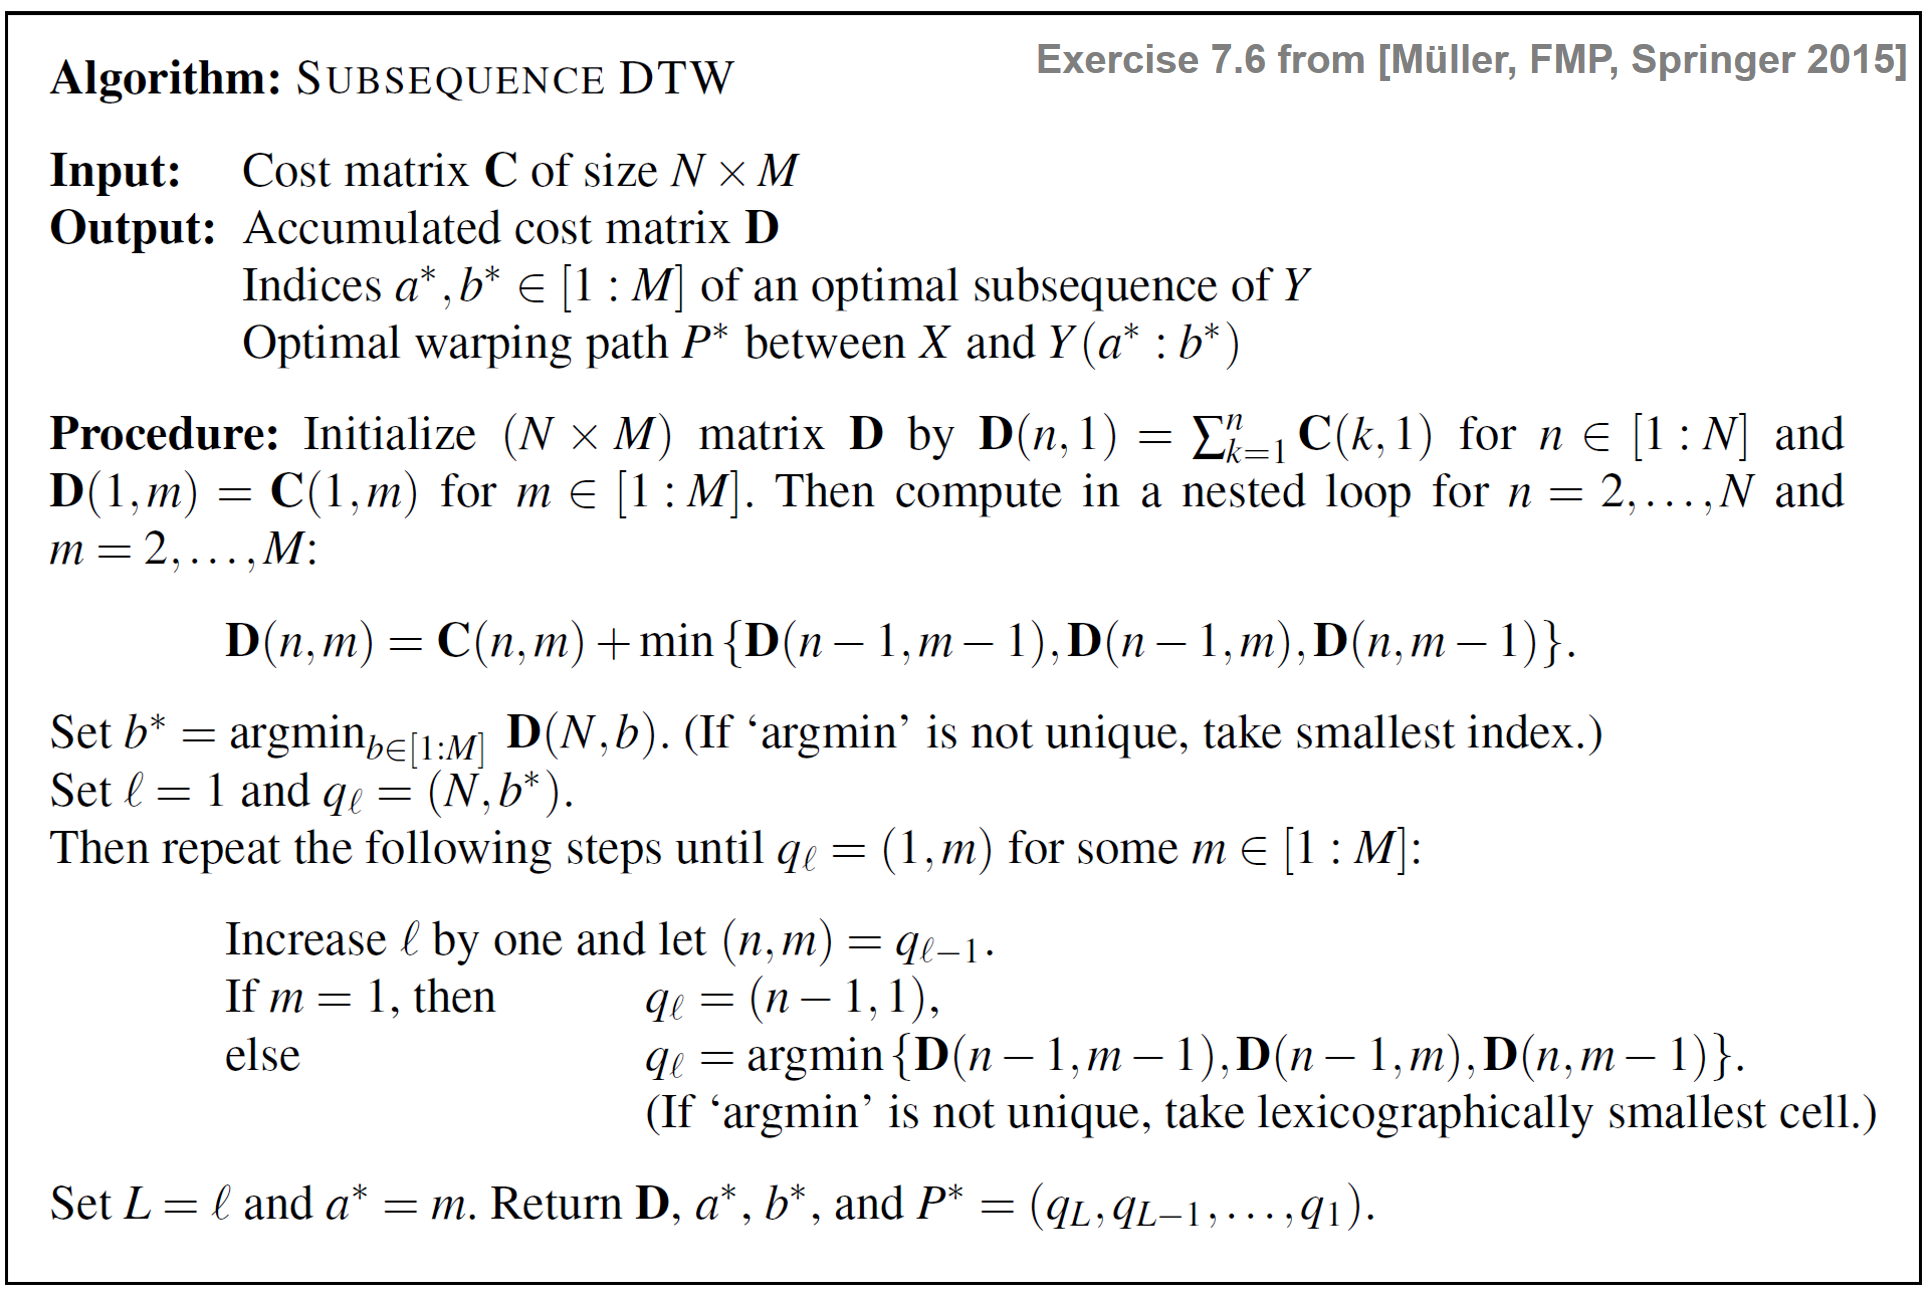

In [22]:
Image(path_img+"FMP_C7_E06.png", width="600px")

We now implement the **Subsequence DTW** algorithm as described above. As an illustrative example, we consider two sequences of real numbers and the absolute value of differences (one-dimensional Euclidean distance) as cost measure. In other words, we have the feature space $\mathcal{F}=\mathbb{R}$ and $c(x,y):=|x-y|$ for $x,y\in \mathcal{F}$.

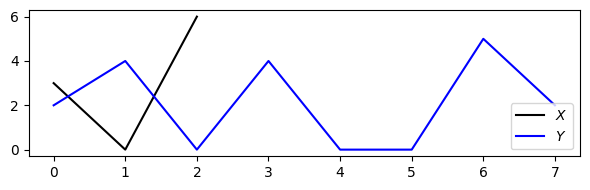

Sequence X = [3 0 6]
Sequence Y = [2 4 0 4 0 0 5 2]


In [20]:
X = np.array([3, 0, 6])
Y = np.array([2, 4, 0, 4, 0, 0, 5, 2])
N = len(X)
M = len(Y)

plt.figure(figsize=(6, 2))
plt.plot(X, c='k', label='$X$')
plt.plot(Y, c='b', label='$Y$')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print('Sequence X =', X)
print('Sequence Y =', Y)

In [21]:
C =  compute_cost_matrix(X, Y, metric='euclidean')
print('Cost matrix C =', C, sep='\n')

Cost matrix C =
[[1. 1. 3. 1. 3. 3. 2. 1.]
 [2. 4. 0. 4. 0. 0. 5. 2.]
 [4. 2. 6. 2. 6. 6. 1. 4.]]


Next, using dynamic programming, we compute the **accumulated cost matrix** $D$ and the cost-minimizing index $b^\ast$ in the last row of $D$.

In [25]:
def compute_accumulated_cost_matrix_subsequence_dtw(C):
    """Given the cost matrix, compute the accumulated cost matrix for
    subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        C (np.ndarray): Cost matrix

    Returns:
        D (np.ndarray): Accumulated cost matrix
    """
    N, M = C.shape
    D = np.zeros((N, M))
    D[:, 0] = np.cumsum(C[:, 0])
    D[0, :] = C[0, :]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

In [26]:
D =  compute_accumulated_cost_matrix_subsequence_dtw(C)
print('Accumulated cost matrix D =', D, sep='\n')
b_ast = D[-1, :].argmin()
print('b* =', b_ast)
print('Accumulated cost D[N, b*] = ', D[-1, b_ast])

Accumulated cost matrix D =
[[1. 1. 3. 1. 3. 3. 2. 1.]
 [3. 5. 1. 5. 1. 1. 6. 3.]
 [7. 5. 7. 3. 7. 7. 2. 6.]]
b* = 6
Accumulated cost D[N, b*] =  2.0


Finally, we derive the optimal warping path $P^\ast$ using backtracking, which determines the index $a^\ast$ of the optimal subsequence $Y(a^\ast:b^\ast)$.

In [27]:
def compute_optimal_warping_path_subsequence_dtw(D, m=-1):
    """Given an accumulated cost matrix, compute the warping path for
    subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        D (np.ndarray): Accumulated cost matrix
        m (int): Index to start back tracking; if set to -1, optimal m is used (Default value = -1)

    Returns:
        P (np.ndarray): Optimal warping path (array of index pairs)
    """
    N, M = D.shape
    n = N - 1
    if m < 0:
        m = D[N - 1, :].argmin()
    P = [(n, m)]

    while n > 0:
        if m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        n, m = cell
    P.reverse()
    P = np.array(P)
    return P

In [28]:
P = compute_optimal_warping_path_subsequence_dtw(D)
print('Optimal warping path P =', P.tolist())
a_ast = P[0, 1]
b_ast = P[-1, 1]
print('a* =', a_ast)
print('b* =', b_ast)
print('Sequence X =', X)
print('Sequence Y =', Y)
print('Optimal subsequence Y(a*:b*) =', Y[a_ast:b_ast+1])
print('Accumulated cost D[N, b_ast]= ', D[-1, b_ast])

Optimal warping path P = [[0, 3], [1, 4], [1, 5], [2, 6]]
a* = 3
b* = 6
Sequence X = [3 0 6]
Sequence Y = [2 4 0 4 0 0 5 2]
Optimal subsequence Y(a*:b*) = [4 0 0 5]
Accumulated cost D[N, b_ast]=  2.0


Finally, we visualize the cost matrix $C$ and the accumulated cost matrix $D$ of our subsequence DTW approach along with the optimal warping path (indicated by the red dots).

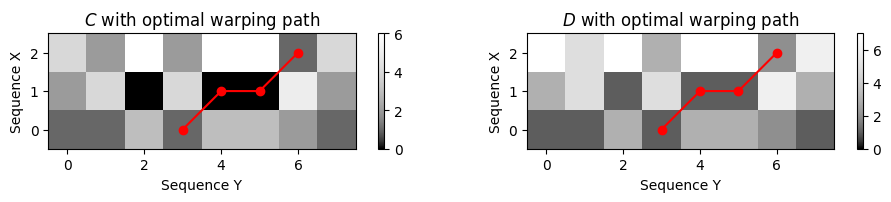

In [29]:
cmap = compressed_gray_cmap(alpha=-10, reverse=True)

plt.figure(figsize=(10, 1.8))
ax = plt.subplot(1, 2, 1)
plot_matrix_with_points(C, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, np.max(C)], cmap=cmap, title='$C$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')

ax = plt.subplot(1, 2, 2)
plot_matrix_with_points(D, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, np.max(D)], cmap=cmap, title='$D$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')

plt.tight_layout()